Tommaso Peritore

In [4]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

from mpl_toolkits.mplot3d import Axes3D

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Activation
from tensorflow.keras import backend as K
from tensorflow.keras.utils import get_custom_objects
from tensorflow.keras import activations

import seaborn as sns
sns.set_theme(style='darkgrid')

%config InlineBackend.figure_format = 'retina'

seed=0
np.random.seed(seed) # fix random seed
tf.random.set_seed(seed)

colors = ['steelblue', 'darkgreen', 'cadetblue', 'forestgreen']

# 11.3

Try to extend the model to fit a simple trigonometric 2D function such as $f(x,y) = \sin(x^2+y^2)$ in the range $x \in [-3/2,3/2]$ and $y \in [-3/2,3/2]$.

## Solution

To tackle this slightly different problem, we can use the same approach as before, but we need to change the model to accept the two variables $x$ and $y$ as inputs. Furthermore, starting from the previous exercises, I found it useful to tweak the parameters slightly, as shown in the code below. After the training I will explain why it is necessary to change the parameters.

Let us define parameters, build and train the model.

In [5]:
# problem parameters
N_epochs = 50
N_train = 10000 # <<< train
N_valid = 1000 # <<< test
sigma = 0.2
bach_size = 32

def f(x, y):
    return np.sin((x ** 2 + y ** 2))

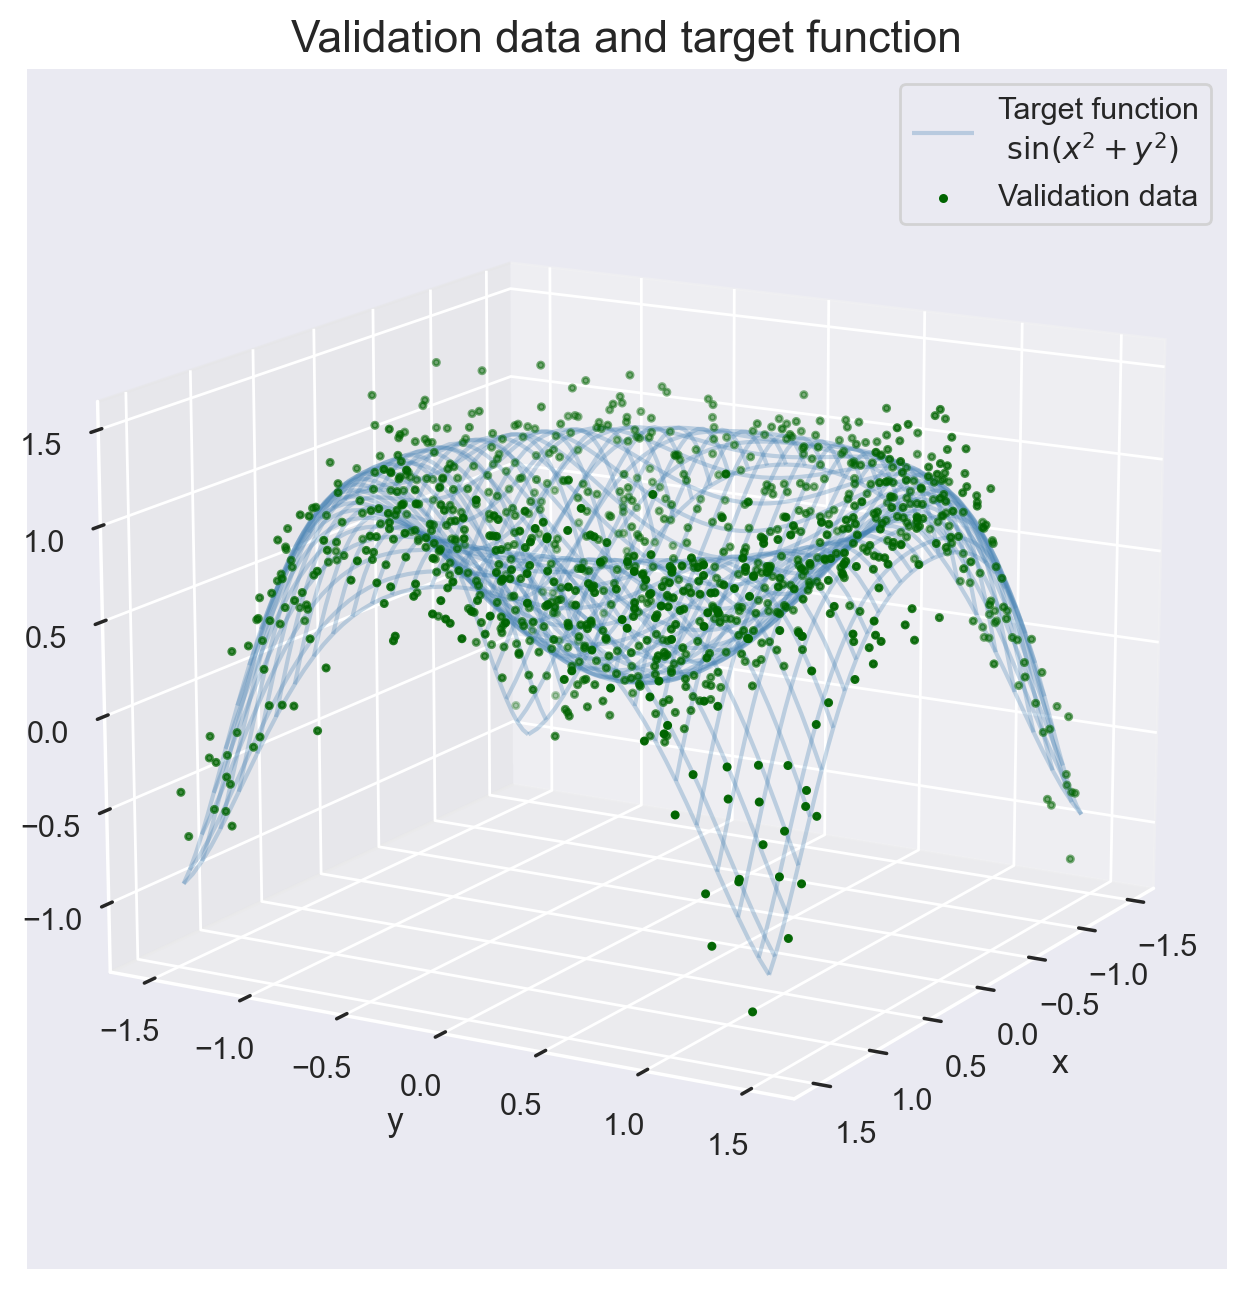

In [6]:
x_train = np.random.uniform(-3./2., 3./2., N_train)
x_valid = np.random.uniform(-3./2., 3./2., N_valid)

y_train = np.random.uniform(-3./2., 3./2., N_train)
y_valid = np.random.uniform(-3./2., 3./2., N_valid)

XY_train = np.column_stack((x_train,y_train))
XY_valid = np.column_stack((x_valid,y_valid))

z_target = f(x_valid, y_valid)
z_train = np.random.normal(f(x_train,y_train), sigma)
z_valid = np.random.normal(f(x_valid,y_valid), sigma)

fig = plt.figure(figsize = (6, 6))
ax = Axes3D(fig)
fig.add_axes(ax)

x_surf = np.arange(-3./2., 3./2., 0.05)
y_surf = np.arange(-3./2., 3./2., 0.05)
X_surf, Y_surf = np.meshgrid(x_surf,y_surf)
ax.plot_wireframe(X_surf, Y_surf, f(X_surf, Y_surf), label = 'Target function\n $\sin(x^2+y^2)$', alpha = 0.3, color = colors[0])
ax.scatter(x_valid, y_valid, z_valid, marker = ".", color = colors[1], label = 'Validation data')
ax.set_xlabel("x")
ax.set_ylabel("y")
ax.set_zlabel("z")
plt.title("Validation data and target function", fontsize = 16)
ax.legend()
ax.view_init(15, 30)

plt.show()

In [7]:
model = tf.keras.Sequential()
act = 'tanh' 
model.add(Dense(32, input_shape = (2,), activation = act))
model.add(Dense(32, activation = act))
model.add(Dense(1, activation = act))

model.compile(optimizer = 'nadam', loss = 'mse', metrics = ['mse'])

# Get a SUMMARY of our composed model
model.summary()

# TRAIN the model

# FIT the model over 50 epochs of 100 batch size each.
# Report training progress against validation data
history = model.fit(x = XY_train, y = z_train, 
               	  batch_size = bach_size, epochs = N_epochs,
                    # shuffle input before each epoch (not mandatory)
                    shuffle = True,                        
                    validation_data = (XY_valid, z_valid))

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 32)                96        
                                                                 
 dense_1 (Dense)             (None, 32)                1056      
                                                                 
 dense_2 (Dense)             (None, 1)                 33        
                                                                 
Total params: 1185 (4.63 KB)
Trainable params: 1185 (4.63 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
Epoch 1/50
313/313 [==============================] - 1s 667us/step - loss: 0.2152 - mse: 0.2152 - val_loss: 0.1816 - val_mse: 0.1816
Epoch 2/50
313/313 [==============================] - 0s 475us/step - loss: 0.1903 - mse: 0.1903 - val_loss: 0.1829 - val_mse: 0.1829
Epoch 3/50
313/313 [

In [8]:
print("RESULTS \n")
w = model.get_weights()

# evaluate with TEST data
print("Test data evaluation")
score = model.evaluate(XY_valid, z_valid, batch_size = bach_size, verbose = 0)
print('Test loss:     ', score[0])
print('Test accuracy: ', score[1])
print()

# evaluate with the EXACT curve
print("Exact curve evaluation")
score = model.evaluate(XY_valid, z_target, batch_size = bach_size, verbose = 0)
print('Test loss:     ', score[0])
print('Test accuracy: ', score[1])

RESULTS 

Test data evaluation
Test loss:      0.043418847024440765
Test accuracy:  0.043418847024440765

Exact curve evaluation
Test loss:      0.0041454853489995
Test accuracy:  0.0041454853489995


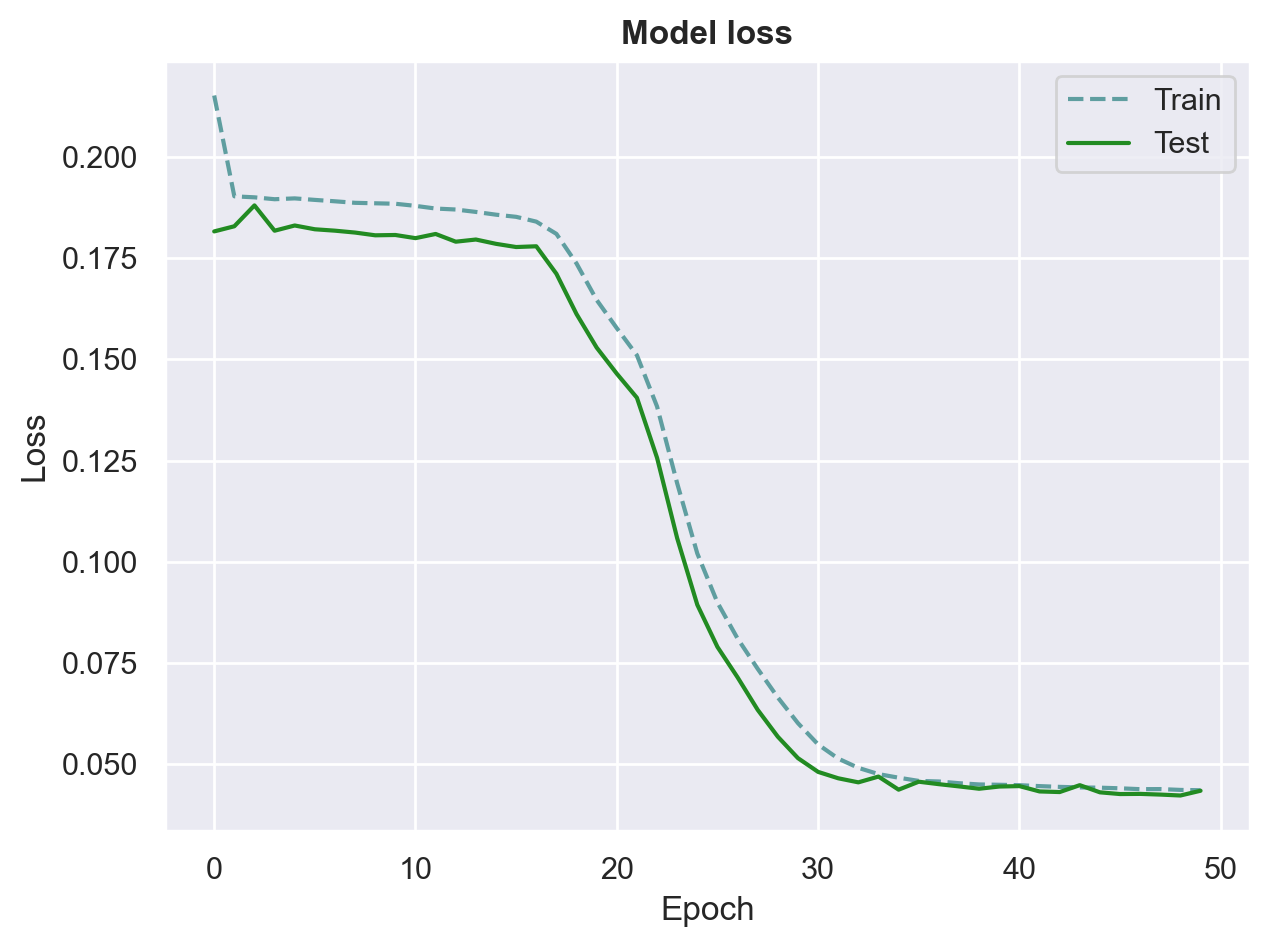

157/157 [==============================] - 0s 308us/step


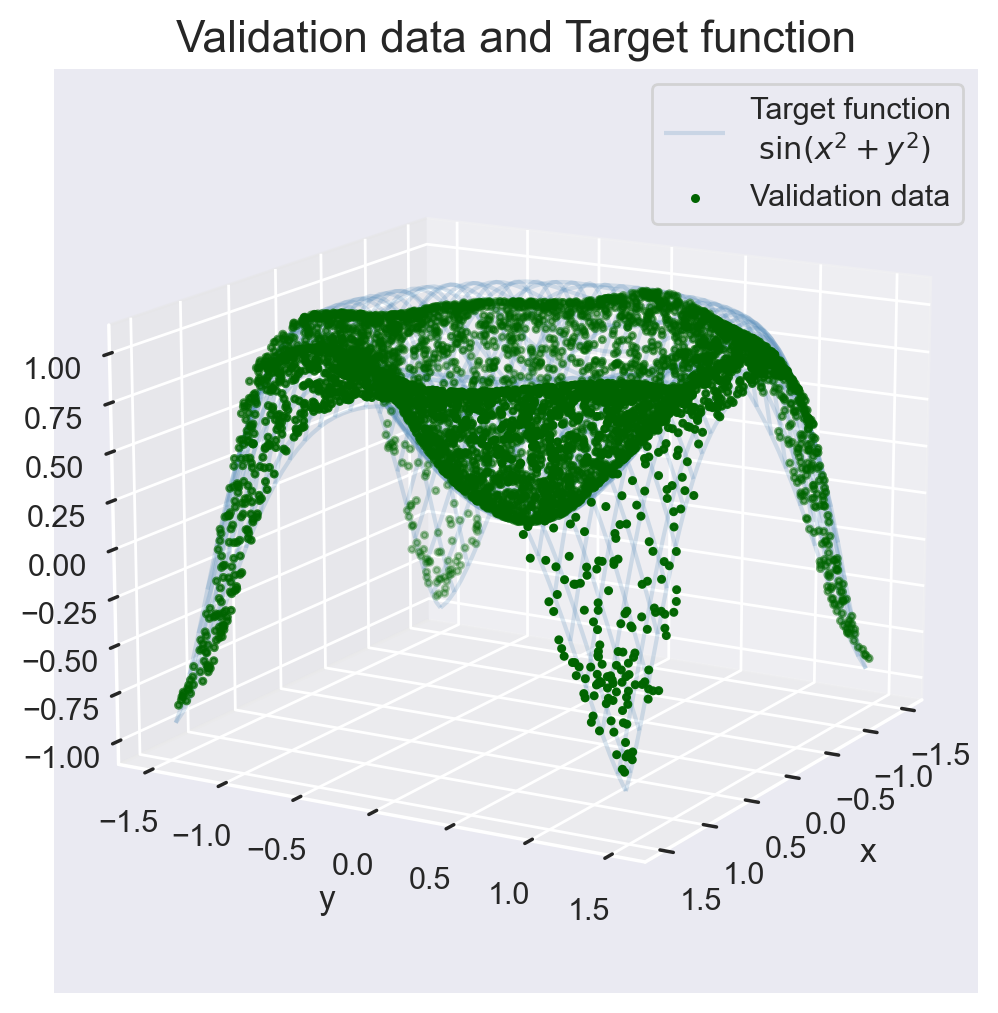

In [9]:

plt.figure(figsize=(7, 5))

# Plot training & validation loss values
plt.plot(history.history['loss'], '--', color = colors[2]) # training loss
plt.plot(history.history['val_loss'], color = colors[3]) # validation loss
plt.title('Model loss', fontweight = "bold")
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='best')
plt.grid(True)
plt.show()


# COMPARE MODEL predictions with TARGET FUNCTION

x_predicted = np.random.uniform(-3./2, 3./2, 5000)
y_predicted = np.random.uniform(-3./2, 3./2, 5000)
XY_predicted = np.column_stack((x_predicted, y_predicted))

z_predicted = model.predict(XY_predicted)

# Plot
fig = plt.figure(figsize=(6, 6))
ax = fig.add_subplot(111, projection='3d')

ax.plot_wireframe( X_surf, Y_surf, f(X_surf,Y_surf), 
                   label = 'Target function\n $\sin(x^2+y^2)$',
						 alpha = 0.2,
						 color = colors[0])
ax.scatter(x_predicted, y_predicted, z_predicted, marker=".", color = colors[1], label='Validation data')
ax.set_xlabel("x")
ax.set_ylabel("y")
ax.set_zlabel("z")
plt.title("Validation data and Target function", fontsize=16)
ax.legend()
ax.view_init(15, 30)

plt.show()

### Comments
First off on the variation of parameters. The upgrade of input size made it necessary to train the model on a lot more data (I saw fit to go from $1000$ as in `11.1-2` to $10000$). Anything less did not give enough data to appreciate the variations of the surface, resulting in a poor fit. Finally, similar considerations brought me to try and increase the number of epochs which however still showed an improvement that saturated around $30$ epochs, as can be seen in the plot above.

For the model I substantially reproposed the neural network structure from the previous exercise, only bringing the input capacity to $2$. 

I also changed the optimizer to `nadam` (Nesterov Adaptive Moment Estimation) which is a variant of `adam` that gave me better results in terms of layers and epochs. According to Keras doc, `nadam`is essentially "Adam with Nesterov momentum", which is a method for accellerated gradient descent. I also changed the activation function to `tanh` which proved more suited to the problem at hand.

These modifications, allowed to model to predict the function with a good accuracy, as shown in the 3D plot above.